In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
from sklearn import preprocessing
from scipy.stats import skew
from scipy.stats import boxcox

# Additional scklearn functions
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn import cross_validation, metrics   
from sklearn.grid_search import GridSearchCV   
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix

# Classifiers
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier  
from sklearn.tree import DecisionTreeClassifier

%matplotlib inline
rcParams['figure.figsize'] = 12, 4


/home/itachi/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/itachi/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
data = pd.read_csv("Training_Dataset.csv")

data.drop(['mvar1','mvar12'], axis=1, inplace=True)

data['card_extension'] = data['mvar46'] + 2*data['mvar47'] + 3*data['mvar48']
data.drop(['mvar46', 'mvar47', 'mvar48'], axis=1, inplace=True)

data['card_acceptance'] = data['mvar49'] + 2*data['mvar50'] + 3*data['mvar51']
data.drop(['mvar49', 'mvar50', 'mvar51'], axis=1, inplace=True)

In [3]:
y_extension = data['card_extension']
y_acceptance = data['card_acceptance']

In [4]:
def is_zero(s):
    return s < 1

var3 = data.pivot_table(values=["mvar3"], index=["mvar2","mvar4","mvar14",'card_extension',"mvar15"], aggfunc=np.mean)
var9 = data.pivot_table(values=["mvar9"], index=["mvar2","mvar4","mvar14",'card_extension',"mvar15"], aggfunc=np.mean)

for i,row in data.loc[is_zero(data['mvar3']),:].iterrows():
    ind = tuple([row['mvar2'],row['mvar4'],row['mvar14'],row['card_extension']])
    data.loc[i,'mvar3'] = var3.loc[ind].values[0]
    
for i,row in data.loc[is_zero(data['mvar9']),:].iterrows():
    ind = tuple([row['mvar2'],row['mvar4'],row['mvar14'],row['card_extension']])
    data.loc[i,'mvar9'] = var9.loc[ind].values[0]


In [13]:
def transformation_plot(var, log_multiply, cbrt_sum, boxcox_var):
    font = {'family': 'serif',
            'color':  'darkred',
            'weight': 'normal',
            'size': 16,
            }
    print("feature : ",var.name)
    plt.figure(figsize=(12, 12))
    plt.subplot(411)
    plt.title('Without transformation')
    simple = var
    skness = skew(simple)
    plt.text(1,8000,"Skewness: {0:.2f}".format(skness),  fontdict=font)
    plt.hist(simple)


    plt.subplot(412) # equivalent to: plt.subplot(2, 2, 1)
    plt.title('Log transformation')
    log_var = np.log(log_multiply*var+1)
    skness_log = skew(log_var)
    plt.hist(log_var)
    plt.text(1,8000,"Skewness: {0:.2f}".format(skness_log),  fontdict=font)

    plt.subplot(413)
    plt.title('cube root transformation')
    cbrt_var = np.cbrt(var+cbrt_sum)
    skness_cbrt = skew(cbrt_var)
    plt.hist(cbrt_var)
    plt.text(1,8000,"Skewness: {0:.2f}".format(skness_cbrt),  fontdict=font)
    
    plt.subplot(414)
    plt.title('boxcox transformation')
    boxcox_var = boxcox(var+boxcox_var)[0]
    skness_boxcox = skew(boxcox_var)
    plt.hist(boxcox_var)
    plt.text(1,8000,"Skewness: {0:.2f}".format(skness_boxcox),  fontdict=font)
    
def classifier_report(clf, X_train, y_train, X_test, y_test, predictors, n_classes=3, classes=[1,2,3],performCV=False, printFeatureImportance=True, cv_folds=2):
    
    #Fit classifies on traning dataset
    clf.fit(X_train[predictors], y_train)
    
    #Predict training and test set:
    dtrain_predictions = clf.predict(X_train[predictors])
    dtrain_predprob = clf.predict_proba(X_train[predictors])
    prediction = clf.predict(X_test[predictors])
    dtest_predprob = clf.predict_proba(X_test[predictors])
    
    #Perform cross-validation:
    if performCV:
        cv_score = cross_validation.cross_val_score(clf, X_train[predictors], y_train, cv=cv_folds)
    
    #Print model report:
    print ("\nModel Report")
    print ("Train Accuracy : %.4g" % metrics.accuracy_score(y_train, dtrain_predictions))
    print ("Test Accuracy : %.4g" % metrics.accuracy_score(y_test, prediction))
    '''
    y = label_binarize(y_train, classes=classes)
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y[:, i], dtrain_predprob[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), dtrain_predprob.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    print("AUC Score (Train): %f" % roc_auc["micro"])  
    
    y1 = label_binarize(y_test, classes=classes)
    # Compute ROC curve and ROC area for each class
    fpr1 = dict()
    tpr1 = dict()
    roc_auc1 = dict()
    for i in range(n_classes):
        fpr1[i], tpr1[i], _ = roc_curve(y1[:, i], dtest_predprob[:, i])
        roc_auc1[i] = auc(fpr1[i], tpr1[i])

    # Compute micro-average ROC curve and ROC area
    fpr1["micro"], tpr1["micro"], _ = roc_curve(y1.ravel(), dtest_predprob.ravel())
    roc_auc1["micro"] = auc(fpr1["micro"], tpr1["micro"])
    print("AUC Score (Test): %f" % roc_auc1["micro"])  
    '''
    if performCV:
        print("CV Score : Mean - %.7g | Std - %.7g | Min - %.7g | Max - %.7g" % (np.mean(cv_score),np.std(cv_score),np.min(cv_score),np.max(cv_score)))
    
    print(confusion_matrix(y_test, prediction))
    
    #Print Feature Importance:
    if printFeatureImportance:
        feat_imp = pd.Series(clf.feature_importances_, predictors).sort_values(ascending=False)
        feat_imp.plot(kind='bar', title='Feature Importances')
        plt.ylabel('Feature Importance Score')
        
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    #http://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

In [6]:
data_ext = data.copy()
data_ext.drop(['cm_key','card_extension','card_acceptance'], axis=1, inplace=True)
data_acc = data.copy()
data_acc.drop(['cm_key','card_extension','card_acceptance'], axis=1, inplace=True)

In [7]:
data_ext['mvar3'] = boxcox(data_ext['mvar3']+100)[0]
data_ext['mvar5'] = boxcox(data_ext['mvar5']+10)[0]
data_ext['mvar8'] = boxcox(data_ext['mvar8']+0.009)[0]
data_ext['mvar9'] = boxcox(data_ext['mvar9']+9)[0]
data_ext['mvar13'] = boxcox(data_ext['mvar13']+1.8)[0]
data_ext['mvar14'] = boxcox(data_ext['mvar14']+0.25)[0]
data_ext['mvar15'] = boxcox(data_ext['mvar15']+0.0000001)[0]
data_ext['mvar16'] = boxcox(data_ext['mvar16']+0.4)[0]
data_ext['mvar17'] = boxcox(data_ext['mvar17']+0.05)[0]
data_ext['mvar18'] = boxcox(data_ext['mvar18']+0.018)[0]
data_ext['mvar19'] = boxcox(data_ext['mvar19']+0.003)[0]
data_ext['mvar20'] = boxcox(data_ext['mvar20']+0.2)[0]
data_ext['mvar24'] = np.log(data_ext['mvar24']+1)
data_ext['mvar25'] = np.log(data_ext['mvar25']+1)
data_ext['mvar26'] = np.log(data_ext['mvar26']+1)
data_ext['mvar27'] = np.log(data_ext['mvar27']+1)
data_ext['mvar28'] = boxcox(data_ext['mvar28']+0.0000001)[0]
data_ext['mvar29'] = boxcox(data_ext['mvar29']+0.0000001)[0]
data_ext['mvar30'] = boxcox(data_ext['mvar30']+0.0000001)[0]
data_ext['mvar31'] = boxcox(data_ext['mvar31']+0.0000001)[0]
data_ext['mvar32'] = np.cbrt(data_ext['mvar32']-2)
data_ext['mvar33'] = np.cbrt(data_ext['mvar33']-2)
data_ext['mvar34'] = np.cbrt(data_ext['mvar34']-2)
data_ext['mvar35'] = np.cbrt(data_ext['mvar35']-2)
data_ext['mvar36'] = boxcox(data_ext['mvar36']+7)[0]
data_ext['mvar37'] = boxcox(data_ext['mvar37']+7)[0]
data_ext['mvar39'] = boxcox(data_ext['mvar39']+7)[0]
data_ext['mvar41'] = boxcox(data_ext['mvar41']+0.0000001)[0]

std_scale = preprocessing.StandardScaler().fit(data_ext)
ext_data = std_scale.transform(data_ext)
ext_data = pd.DataFrame(ext_data)
ext_data.columns = ['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9',
                    'mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17',
                    'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24',
                    'mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31',
                    'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38',
                    'mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45']

In [8]:
data_acc['mvar2'] = boxcox(data_acc['mvar2']+0.01)[0]
data_acc['mvar3'] = boxcox(data_acc['mvar3']+100)[0]
data_acc['mvar4'] = np.cbrt(data_acc['mvar4']+0.68)
data_acc['mvar6'] = np.cbrt(data_acc['mvar6']+14.5)
data_acc['mvar7'] = boxcox(data_acc['mvar7'])[0]
data_acc['mvar8'] = boxcox(data_acc['mvar8']+0.009)[0]
data_acc['mvar9'] = boxcox(data_acc['mvar9']+9)[0]
data_acc['mvar13'] = boxcox(data_acc['mvar13']+1.8)[0]
data_acc['mvar15'] = boxcox(data_acc['mvar15']+0.0000001)[0]
data_acc['mvar16'] = boxcox(data_acc['mvar16']+0.4)[0]
data_acc['mvar17'] = boxcox(data_acc['mvar17']+0.05)[0]
data_acc['mvar18'] = boxcox(data_acc['mvar18']+0.018)[0]
data_acc['mvar19'] = boxcox(data_acc['mvar19']+0.003)[0]
data_acc['mvar20'] = boxcox(data_acc['mvar20']+0.2)[0]
data_acc['mvar21'] = boxcox(data_acc['mvar21']+0.0000001)[0]
data_acc['mvar22'] = boxcox(data_acc['mvar22']+0.0000001)[0]
data_acc['mvar23'] = boxcox(data_acc['mvar23']+0.0000001)[0]
data_acc['mvar24'] = np.log(data_acc['mvar24']+1)
data_acc['mvar25'] = np.log(data_acc['mvar25']+1)
data_acc['mvar26'] = np.log(data_acc['mvar26']+1)
data_acc['mvar27'] = np.log(data_acc['mvar27']+1)
data_acc['mvar28'] = boxcox(data_acc['mvar28']+0.0000001)[0]
data_acc['mvar29'] = boxcox(data_acc['mvar29']+0.0000001)[0]
data_acc['mvar30'] = boxcox(data_acc['mvar30']+0.0000001)[0]
data_acc['mvar31'] = boxcox(data_acc['mvar31']+0.0000001)[0]
data_acc['mvar32'] = np.cbrt(data_acc['mvar32']-2)
data_acc['mvar33'] = np.cbrt(data_acc['mvar33']-2)
data_acc['mvar34'] = np.cbrt(data_acc['mvar34']-2)
data_acc['mvar35'] = np.cbrt(data_acc['mvar35']-2)
data_acc['mvar36'] = boxcox(data_acc['mvar36']+7)[0]
data_acc['mvar37'] = boxcox(data_acc['mvar37']+7)[0]
data_acc['mvar38'] = boxcox(data_acc['mvar38']+7)[0]
data_acc['mvar39'] = boxcox(data_acc['mvar39']+7)[0]
data_acc['mvar40'] = boxcox(data_acc['mvar40']+0.0000001)[0]
data_acc['mvar41'] = boxcox(data_acc['mvar41']+0.0000001)[0]
data_acc['mvar42'] = boxcox(data_acc['mvar42']+0.0000001)[0]
data_acc['mvar43'] = boxcox(data_acc['mvar43']+0.0000001)[0]

std_scale = preprocessing.StandardScaler().fit(data_acc)
acc_data = std_scale.transform(data_acc)
acc_data = pd.DataFrame(acc_data)
acc_data.columns = ['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9',
       'mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17',
       'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24',
       'mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31',
       'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38',
       'mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45',]

In [10]:
X1_train, X1_test,y_train_acceptance,y_test_acceptance,y_train_extension,y_test_extension = train_test_split(ext_data, y_acceptance, y_extension, test_size=0.20, random_state=659)

In [11]:
from sklearn.decomposition import PCA

pca = PCA(n_components=25).fit(ext_data)
X2_train = pca.transform(X1_train)
X2_test = pca.transform(X1_test)

X2_train = pd.DataFrame(X2_train)
X2_test = pd.DataFrame(X2_test)

X1_train.reset_index(drop=True, inplace=True)
X1_test.reset_index(drop=True, inplace=True)

X_ext_train = pd.concat([X1_train, X2_train], ignore_index=True, axis=1)
X_ext_test = pd.concat([X1_test, X2_test], ignore_index=True, axis=1)

print(X1_train.shape + X1_test.shape)
print(X2_train.shape + X2_test.shape)
print(X_ext_train.shape + X_ext_test.shape)

(32000, 43, 8000, 43)
(32000, 25, 8000, 25)
(32000, 68, 8000, 68)


In [102]:
# ext classifier
from xgboost import XGBClassifier

ext_predictors = [x for x in X_ext_train.columns]

xgb_ext = XGBClassifier(max_depth=6, learning_rate=0.01, n_estimators=1500, objective='binary:logistic',
                    nthread=-1, gamma=0, min_child_weight=2, subsample=0.90, colsample_bytree=1,
                    scale_pos_weight=1)

#classifier_report(xgb_ext, X_ext_train, y_train_extension, X_ext_test, y_test_extension, ext_predictors)


xgb_ext.fit(X_ext_train,y_train_extension)

prediction = xgb_ext.predict(X_ext_test)

print(xgb_ext.score(X_ext_train,y_train_extension))

print(xgb_ext.score(X_ext_test,y_test_extension))

print(confusion_matrix(y_test_extension, prediction))


0.64384375
0.413625
[[3176  107   80]
 [2221   81   51]
 [2153   79   52]]


In [15]:
pca = PCA(n_components=25).fit(ext_data)

ext_data_pca = pca.transform(ext_data)

ext_data_pca = pd.DataFrame(ext_data_pca)

ext_data_pca.reset_index(drop=True, inplace=True)
ext_data.reset_index(drop=True, inplace=True)

ext_train = pd.concat([ext_data, ext_data_pca], ignore_index=True, axis=1)

ext_train.columns

RangeIndex(start=0, stop=68, step=1)

In [16]:
y_pred = xgb_ext.predict(ext_train)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['y_pres']

acc_data = pd.concat([acc_data, y_pred],axis=1)

In [17]:
acc_data.columns

Index(['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9',
       'mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17',
       'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24',
       'mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31',
       'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38',
       'mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45',
       'y_pres'],
      dtype='object')

In [18]:
X3_train, X3_test,y_train_acceptance,y_test_acceptance,y_train_extension,y_test_extension = train_test_split(acc_data, y_acceptance, y_extension, test_size=0.20,stratify=y_acceptance, random_state=659)

In [19]:
X3_train = pd.concat([X3_train, y_train_extension], axis=1)
X3_train.drop('y_pres',axis=1,inplace=True)


In [20]:
X3_train.columns = ['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9',
       'mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17',
       'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24',
       'mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31',
       'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38',
       'mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45',
       'y_pres']

In [21]:
X3_test.columns

Index(['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9',
       'mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17',
       'mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24',
       'mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31',
       'mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38',
       'mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45',
       'y_pres'],
      dtype='object')

In [87]:
pca = PCA(n_components=22).fit(acc_data)
X4_train = pca.transform(X3_train)
X4_test = pca.transform(X3_test)

X4_train = pd.DataFrame(X4_train)
X4_test = pd.DataFrame(X4_test)

X3_train.reset_index(drop=True, inplace=True)
X3_test.reset_index(drop=True, inplace=True)

X_acc_train = pd.concat([X3_train, X4_train], ignore_index=True, axis=1)
X_acc_test = pd.concat([X3_test, X4_test], ignore_index=True, axis=1)

print(X3_train.shape + X3_test.shape)
print(X4_train.shape + X4_test.shape)
print(X_acc_train.shape + X_acc_test.shape)

(32000, 44, 8000, 44)
(32000, 22, 8000, 22)
(32000, 66, 8000, 66)


In [88]:
from xgboost import XGBClassifier

predictors = [x for x in X_acc_test.columns]

In [89]:
unique, counts = np.unique(y_train_acceptance, return_counts=True)
print('full confidence')
print(np.asarray((unique, counts)).T)

print("*********************")

unique, counts = np.unique(y_test_acceptance, return_counts=True)
print('full confidence')
print(np.asarray((unique, counts)).T)

full confidence
[[    0 24897]
 [    1  2758]
 [    2  2123]
 [    3  2222]]
*********************
full confidence
[[   0 6225]
 [   1  689]
 [   2  531]
 [   3  555]]


In [90]:
X_acc_train.reset_index(drop=True, inplace=True)
y_train_acceptance.reset_index(drop=True, inplace=True)
newdata = pd.concat([X_acc_train, y_train_acceptance], axis=1)

zero = newdata[newdata['card_acceptance'] == 0]
one = newdata[newdata['card_acceptance'] == 1]
two = newdata[newdata['card_acceptance'] == 2]
three = newdata[newdata['card_acceptance'] == 3]

zeroth = zero
train = pd.concat([zeroth,one,two,three], axis=0)

y_train = train['card_acceptance']
train.drop('card_acceptance', axis=1, inplace=True)

train = pd.DataFrame(train)
print(train.shape)

xgb_acc2 = XGBClassifier(max_depth=6, learning_rate=0.01, n_estimators=1100, objective='binary:logistic',
                    nthread=-1, gamma=0, min_child_weight=4, subsample=0.80, colsample_bytree=1,
                    scale_pos_weight=1, seed = 55689)

xgb_acc2.fit(train,y_train)
prediction = xgb_acc2.predict(X_acc_test)
print(xgb_acc2.score(train,y_train))
print(xgb_acc2.score(X_acc_test,y_test_acceptance))
print(confusion_matrix(y_test_acceptance, prediction))


(32000, 66)
0.84209375
0.784
[[6045   37   62   81]
 [ 636   41    9    3]
 [ 463    1   64    3]
 [ 426    1    6  122]]


In [91]:
unique, counts = np.unique(y_train_acceptance, return_counts=True)
print('full confidence')
print(np.asarray((unique, counts)).T)

full confidence
[[    0 24897]
 [    1  2758]
 [    2  2123]
 [    3  2222]]


In [92]:
y_new_train_acceptance = y_train_acceptance.replace([1,2,3],[1,1,1])
unique, counts = np.unique(y_new_train_acceptance, return_counts=True)
print('full confidence')
print(np.asarray((unique, counts)).T)

full confidence
[[    0 24897]
 [    1  7103]]


In [93]:
y_new_test_acceptance = y_test_acceptance.replace([1,2,3],[1,1,1])
unique, counts = np.unique(y_new_test_acceptance, return_counts=True)
print('full confidence')
print(np.asarray((unique, counts)).T)

full confidence
[[   0 6225]
 [   1 1775]]


(17103, 66)

Model Report
Train Accuracy : 0.8139
Test Accuracy : 0.7196
[[4946 1279]
 [ 964  811]]


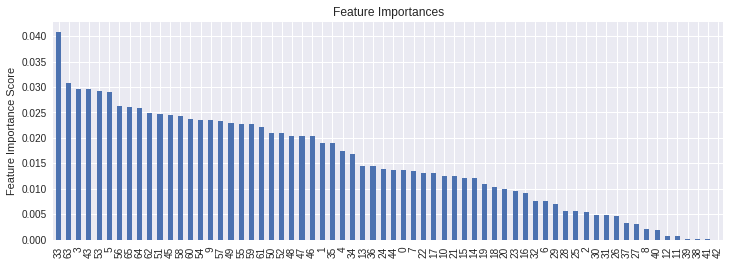

In [94]:
X_acc_train.reset_index(drop=True, inplace=True)
y_new_train_acceptance.reset_index(drop=True, inplace=True)
newdata = pd.concat([X_acc_train, y_new_train_acceptance], axis=1)

zero = newdata[newdata['card_acceptance'] == 0]
one = newdata[newdata['card_acceptance'] == 1]

zeroth = zero[:10000]
train = pd.concat([zeroth,one], axis=0)

y_train = train['card_acceptance']
train.drop('card_acceptance', axis=1, inplace=True)

train = pd.DataFrame(train)
print(train.shape)

train_predictors = [x for x in train.columns]


xgb_con = XGBClassifier(max_depth=6, learning_rate=0.01, n_estimators=1000, objective='binary:logistic',
                    nthread=-1, gamma=0, min_child_weight=6, subsample=0.80, colsample_bytree=1,
                    scale_pos_weight=1, seed = 55689)

classifier_report(xgb_con, train, y_train, X_acc_test, y_new_test_acceptance, train_predictors, n_classes=2, classes=[0,1])

(20000, 66)

Model Report
Train Accuracy : 0.8493
Test Accuracy : 0.7559
[[5440  785]
 [1168  607]]


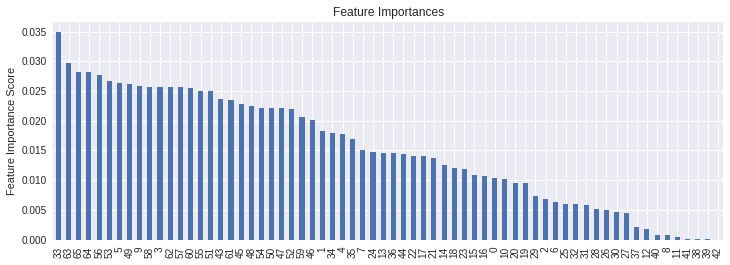

In [95]:
X_acc_train.reset_index(drop=True, inplace=True)
y_new_train_acceptance.reset_index(drop=True, inplace=True)
newdata = pd.concat([X_acc_train, y_new_train_acceptance], axis=1)

zero = newdata[newdata['card_acceptance'] == 0]
one = newdata[newdata['card_acceptance'] == 1]

zeroth = zero[12000:]
train = pd.concat([zeroth,one], axis=0)

y_train = train['card_acceptance']
train.drop('card_acceptance', axis=1, inplace=True)

train = pd.DataFrame(train)
print(train.shape)


xgb_con3 = XGBClassifier(max_depth=6, learning_rate=0.01, n_estimators=1500, objective='binary:logistic',
                    nthread=-1, gamma=0, min_child_weight=3, subsample=0.80, colsample_bytree=1,
                    scale_pos_weight=1, seed = 55689)

classifier_report(xgb_con3, train, y_train, X_acc_test, y_new_test_acceptance, train_predictors, n_classes=2, classes=[0,1])



(21103, 66)

Model Report
Train Accuracy : 0.9455
Test Accuracy : 0.7652
[[5605  620]
 [1258  517]]


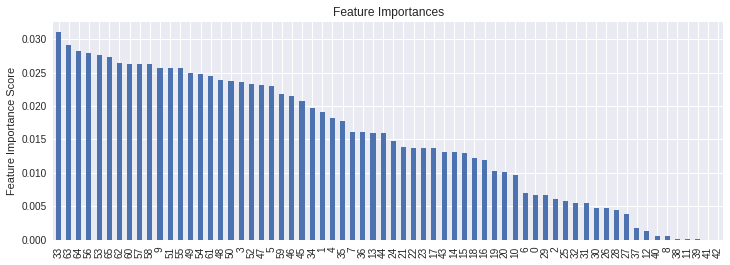

In [96]:
X_acc_train.reset_index(drop=True, inplace=True)
y_new_train_acceptance.reset_index(drop=True, inplace=True)
newdata = pd.concat([X_acc_train, y_new_train_acceptance], axis=1)

zero = newdata[newdata['card_acceptance'] == 0]
one = newdata[newdata['card_acceptance'] == 1]

zeroth = zero[8000:22000]
train = pd.concat([zeroth,one], axis=0)

y_train = train['card_acceptance']
train.drop('card_acceptance', axis=1, inplace=True)

train = pd.DataFrame(train)
print(train.shape)


xgb_con4 = XGBClassifier(max_depth=9, learning_rate=0.01, n_estimators=1000, objective='binary:logistic',
                    nthread=-1, gamma=0, min_child_weight=3, subsample=0.80, colsample_bytree=1,
                    scale_pos_weight=1, seed = 55689)

classifier_report(xgb_con4, train, y_train, X_acc_test, y_new_test_acceptance, train_predictors, n_classes=2, classes=[0,1])



(32000, 66)

Model Report
Train Accuracy : 0.8833
Test Accuracy : 0.7836
[[6073  152]
 [1579  196]]


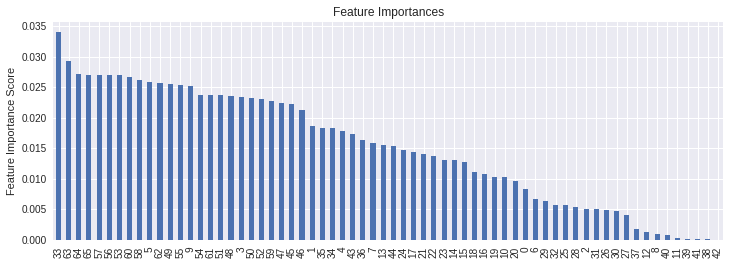

In [97]:
X_acc_train.reset_index(drop=True, inplace=True)
y_new_train_acceptance.reset_index(drop=True, inplace=True)
newdata = pd.concat([X_acc_train, y_new_train_acceptance], axis=1)

zero = newdata[newdata['card_acceptance'] == 0]
one = newdata[newdata['card_acceptance'] == 1]

zeroth = zero
train = pd.concat([zeroth,one], axis=0)

y_train = train['card_acceptance']
train.drop('card_acceptance', axis=1, inplace=True)

train = pd.DataFrame(train)
print(train.shape)



xgb_con2 = XGBClassifier(max_depth=8, learning_rate=0.01, n_estimators=1500, objective='binary:logistic',
                    nthread=-1, gamma=0, min_child_weight=6, subsample=0.80, colsample_bytree=1,
                    scale_pos_weight=1, seed = 55689)

classifier_report(xgb_con2, train, y_train, X_acc_test, y_new_test_acceptance, train_predictors, n_classes=2, classes=[0,1])

In [98]:
X_acc_train.reset_index(drop=True, inplace=True)
y_new_train_acceptance.reset_index(drop=True, inplace=True)
newdata = pd.concat([X_acc_train, y_new_train_acceptance], axis=1)

zero = newdata[newdata['card_acceptance'] == 0]
one = newdata[newdata['card_acceptance'] == 1]

zeroth = zero[8000:22000]
train = pd.concat([zeroth,one], axis=0)

y_train = train['card_acceptance']
train.drop('card_acceptance', axis=1, inplace=True)

train = pd.DataFrame(train)
print(train.shape)

from sklearn.neural_network import MLPClassifier

mlp1 = MLPClassifier(hidden_layer_sizes=(100,100,100,100,100,100), activation='logistic', max_iter=20000, tol=0.00001)


classifier_report(mlp1, train, y_train, X_acc_test, y_new_test_acceptance, train_predictors, n_classes=2, classes=[0,1])

(21103, 66)

Model Report
Train Accuracy : 0.8028
Test Accuracy : 0.7173
[[5222 1003]
 [1259  516]]


AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

In [ ]:
prob1 = xgb_con.predict_proba(X_acc_test)
pred1 = prob1 > 0.52
pred1 = pd.DataFrame(pred1[:,1])
pred1 = 1*pred1
print(confusion_matrix(y_new_test_acceptance, pred1))
prob1 = pd.DataFrame(prob1[:,1])


In [ ]:
prob2= xgb_con2.predict_proba(X_acc_test)
pred2 = prob2 > 0.35
pred2 = pd.DataFrame(pred2[:,1])
pred2 = 1*pred2
print(confusion_matrix(y_new_test_acceptance, pred2))
prob2 = pd.DataFrame(prob2[:,1])


In [ ]:
prob3 = xgb_con3.predict_proba(X_acc_test)
pred3 = prob3 > 0.50
pred3 = pd.DataFrame(pred3[:,1])
pred3 = 1*pred3
print(confusion_matrix(y_new_test_acceptance, pred3))
prob3 = pd.DataFrame(prob3[:,1])


In [ ]:
prob4 = mlp1.predict_proba(X_acc_test)
pred4 = prob4 > 0.15
pred4 = pd.DataFrame(pred4[:,1])
pred4 = 1*pred4
print(confusion_matrix(y_new_test_acceptance, pred4))
prob4 = pd.DataFrame(prob4[:,1])


In [42]:
y_new_test_acceptance.reset_index(drop=True, inplace=True)
pred = pd.concat([y_new_test_acceptance,pred1,pred2,pred3,prob1,prob2,prob3], axis=1)
pred.columns = ['card_acceptance','pred1', 'pred2', 'pred3','prob1','prob2','prob3']

In [43]:
new = pred[pred['pred1']==1]
new1 = new[new['pred2']==1]
new4 = new1[new1['pred3']==1]
#new4 = new2[new2['pred4']==1]
#new4 = new3[new3['pred5']==1]


In [59]:
X_acc_test.columns

RangeIndex(start=0, stop=69, step=1)

In [44]:
new4.shape

(1030, 7)

In [45]:
new4[new4['card_acceptance']==1].shape

(480, 7)

In [47]:
new4['sum_prob'] = new4['prob1']+new4['prob2']+new4['prob3']
new4.sort_values('sum_prob', ascending=False).to_csv('pred1.csv')

/home/itachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [48]:
haha = pd.read_csv("Leaderboard_Dataset.csv")

In [49]:
haha.drop(['mvar1','mvar12'], axis=1, inplace=True)

In [50]:
def is_zero(s):
    return s < 1

var3 = haha.pivot_table(values=["mvar3"], index=["mvar2","mvar4","mvar14","mvar15"], aggfunc=np.mean)
var9 = haha.pivot_table(values=["mvar9"], index=["mvar2","mvar4","mvar14","mvar15"], aggfunc=np.mean)

for i,row in haha.loc[is_zero(haha['mvar3']),:].iterrows():
    ind = tuple([row['mvar2'],row['mvar4'],row['mvar14']])
    haha.loc[i,'mvar3'] = var3.loc[ind].values[0]
    
for i,row in haha.loc[is_zero(haha['mvar9']),:].iterrows():
    ind = tuple([row['mvar2'],row['mvar4'],row['mvar14']])
    haha.loc[i,'mvar9'] = var9.loc[ind].values[0]

In [51]:
cm_key = haha['cm_key']
haha.drop('cm_key', axis=1, inplace=True)

In [52]:
haha_ext = haha.copy()
haha_acc = haha.copy()

In [53]:
haha_ext['mvar3'] = boxcox(haha_ext['mvar3']+100)[0]
haha_ext['mvar5'] = boxcox(haha_ext['mvar5']+10)[0]
haha_ext['mvar8'] = boxcox(haha_ext['mvar8']+0.009)[0]
haha_ext['mvar9'] = boxcox(haha_ext['mvar9']+9)[0]
haha_ext['mvar13'] = boxcox(haha_ext['mvar13']+1.8)[0]
haha_ext['mvar14'] = boxcox(haha_ext['mvar14']+0.25)[0]
haha_ext['mvar15'] = boxcox(haha_ext['mvar15']+0.0000001)[0]
haha_ext['mvar16'] = boxcox(haha_ext['mvar16']+0.4)[0]
haha_ext['mvar17'] = boxcox(haha_ext['mvar17']+0.05)[0]
haha_ext['mvar18'] = boxcox(haha_ext['mvar18']+0.018)[0]
haha_ext['mvar19'] = boxcox(haha_ext['mvar19']+0.003)[0]
haha_ext['mvar20'] = boxcox(haha_ext['mvar20']+0.2)[0]
haha_ext['mvar24'] = np.log(haha_ext['mvar24']+1)
haha_ext['mvar25'] = np.log(haha_ext['mvar25']+1)
haha_ext['mvar26'] = np.log(haha_ext['mvar26']+1)
haha_ext['mvar27'] = np.log(haha_ext['mvar27']+1)
haha_ext['mvar28'] = boxcox(haha_ext['mvar28']+0.0000001)[0]
haha_ext['mvar29'] = boxcox(haha_ext['mvar29']+0.0000001)[0]
haha_ext['mvar30'] = boxcox(haha_ext['mvar30']+0.0000001)[0]
haha_ext['mvar31'] = boxcox(haha_ext['mvar31']+0.0000001)[0]
haha_ext['mvar32'] = np.cbrt(haha_ext['mvar32']-2)
haha_ext['mvar33'] = np.cbrt(haha_ext['mvar33']-2)
haha_ext['mvar34'] = np.cbrt(haha_ext['mvar34']-2)
haha_ext['mvar35'] = np.cbrt(haha_ext['mvar35']-2)
haha_ext['mvar36'] = boxcox(haha_ext['mvar36']+7)[0]
haha_ext['mvar37'] = boxcox(haha_ext['mvar37']+7)[0]
haha_ext['mvar39'] = boxcox(haha_ext['mvar39']+7)[0]
haha_ext['mvar41'] = boxcox(haha_ext['mvar41']+0.0000001)[0]

std_scale = preprocessing.StandardScaler().fit(haha_ext)
ext_haha = std_scale.transform(haha_ext)
ext_haha = pd.DataFrame(ext_haha)
ext_haha.columns = ['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9','mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17','mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24','mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31','mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38','mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45']

In [54]:
haha_acc['mvar2'] = boxcox(haha_acc['mvar2']+0.01)[0]
haha_acc['mvar3'] = boxcox(haha_acc['mvar3']+100)[0]
haha_acc['mvar4'] = np.cbrt(haha_acc['mvar4']+0.68)
haha_acc['mvar6'] = np.cbrt(haha_acc['mvar6']+14.5)
haha_acc['mvar7'] = boxcox(haha_acc['mvar7'])[0]
haha_acc['mvar8'] = boxcox(haha_acc['mvar8']+0.009)[0]
haha_acc['mvar9'] = boxcox(haha_acc['mvar9']+9)[0]
haha_acc['mvar13'] = boxcox(haha_acc['mvar13']+1.8)[0]
haha_acc['mvar15'] = boxcox(haha_acc['mvar15']+0.0000001)[0]
haha_acc['mvar16'] = boxcox(haha_acc['mvar16']+0.4)[0]
haha_acc['mvar17'] = boxcox(haha_acc['mvar17']+0.05)[0]
haha_acc['mvar18'] = boxcox(haha_acc['mvar18']+0.018)[0]
haha_acc['mvar19'] = boxcox(haha_acc['mvar19']+0.003)[0]
haha_acc['mvar20'] = boxcox(haha_acc['mvar20']+0.2)[0]
haha_acc['mvar21'] = boxcox(haha_acc['mvar21']+0.0000001)[0]
haha_acc['mvar22'] = boxcox(haha_acc['mvar22']+0.0000001)[0]
haha_acc['mvar23'] = boxcox(haha_acc['mvar23']+0.0000001)[0]
haha_acc['mvar24'] = np.log(haha_acc['mvar24']+1)
haha_acc['mvar25'] = np.log(haha_acc['mvar25']+1)
haha_acc['mvar26'] = np.log(haha_acc['mvar26']+1)
haha_acc['mvar27'] = np.log(haha_acc['mvar27']+1)
haha_acc['mvar28'] = boxcox(haha_acc['mvar28']+0.0000001)[0]
haha_acc['mvar29'] = boxcox(haha_acc['mvar29']+0.0000001)[0]
haha_acc['mvar30'] = boxcox(haha_acc['mvar30']+0.0000001)[0]
haha_acc['mvar31'] = boxcox(haha_acc['mvar31']+0.0000001)[0]
haha_acc['mvar32'] = np.cbrt(haha_acc['mvar32']-2)
haha_acc['mvar33'] = np.cbrt(haha_acc['mvar33']-2)
haha_acc['mvar34'] = np.cbrt(haha_acc['mvar34']-2)
haha_acc['mvar35'] = np.cbrt(haha_acc['mvar35']-2)
haha_acc['mvar36'] = boxcox(haha_acc['mvar36']+7)[0]
haha_acc['mvar37'] = boxcox(haha_acc['mvar37']+7)[0]
haha_acc['mvar38'] = boxcox(haha_acc['mvar38']+7)[0]
haha_acc['mvar39'] = boxcox(haha_acc['mvar39']+7)[0]
haha_acc['mvar40'] = boxcox(haha_acc['mvar40']+0.0000001)[0]
haha_acc['mvar41'] = boxcox(haha_acc['mvar41']+0.0000001)[0]
haha_acc['mvar42'] = boxcox(haha_acc['mvar42']+0.0000001)[0]
haha_acc['mvar43'] = boxcox(haha_acc['mvar43']+0.0000001)[0]

std_scale = preprocessing.StandardScaler().fit(haha_acc)
acc_haha = std_scale.transform(haha_acc)
acc_haha = pd.DataFrame(acc_haha)
acc_haha.columns = ['mvar2', 'mvar3', 'mvar4', 'mvar5', 'mvar6', 'mvar7', 'mvar8', 'mvar9','mvar10', 'mvar11', 'mvar13', 'mvar14', 'mvar15', 'mvar16', 'mvar17','mvar18', 'mvar19', 'mvar20', 'mvar21', 'mvar22', 'mvar23', 'mvar24','mvar25', 'mvar26', 'mvar27', 'mvar28', 'mvar29', 'mvar30', 'mvar31','mvar32', 'mvar33', 'mvar34', 'mvar35', 'mvar36', 'mvar37', 'mvar38','mvar39', 'mvar40', 'mvar41', 'mvar42', 'mvar43', 'mvar44', 'mvar45']

In [55]:
pca = PCA(n_components=25).fit(ext_data)
ext_haha1 = pca.transform(ext_haha)

ext_haha1 = pd.DataFrame(ext_haha1)

ext_haha1.reset_index(drop=True, inplace=True)

leaderboard_ext = pd.concat([ext_haha, ext_haha1], ignore_index=True, axis=1)

print(leaderboard_ext.shape)

(10000, 68)


In [56]:
y_pred = xgb_ext.predict(leaderboard_ext)
y_pred = pd.DataFrame(y_pred)
y_pred.columns = ['y_pres']

acc_haha = pd.concat([acc_haha, y_pred],axis=1)

In [85]:

pca = PCA(n_components=22).fit(acc_data)
acc_haha1 = pca.transform(acc_haha)

acc_haha1 = pd.DataFrame(acc_haha1)

acc_haha1.reset_index(drop=True, inplace=True)

leaderboard_acc = pd.concat([acc_haha, acc_haha1], ignore_index=True, axis=1)

print(leaderboard_acc.shape)

(10000, 66)


In [86]:
prob1 = xgb_con.predict_proba(leaderboard_acc)
pred1 = prob1 > 0.52
pred1 = pd.DataFrame(pred1[:,1])
pred1 = 1*pred1
prob1 = pd.DataFrame(prob1[:,1])

prob2= xgb_con2.predict_proba(leaderboard_acc)
pred2 = prob2 > 0.35
pred2 = pd.DataFrame(pred2[:,1])
pred2 = 1*pred2
prob2 = pd.DataFrame(prob2[:,1])

prob3 = xgb_con3.predict_proba(leaderboard_acc)
pred3 = prob3 > 0.50
pred3 = pd.DataFrame(pred3[:,1])
pred3 = 1*pred3
prob3 = pd.DataFrame(prob3[:,1])


ValueError: feature_names mismatch: ['0 ', '1 ', '2 ', '3 ', '4 ', '5 ', '6 ', '7 ', '8 ', '9 ', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68'] ['0 ', '1 ', '2 ', '3 ', '4 ', '5 ', '6 ', '7 ', '8 ', '9 ', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65']
expected 68, 66, 67 in input data

In [62]:
pred = pd.concat([cm_key,pred1,pred2,pred3,prob1,prob2,prob3], axis=1)
pred.columns = ['cm_key','pred1','pred2','pred3','prob1','prob2','prob3']

In [63]:
new = pred[pred['pred1']==1]
new1 = new[new['pred2']==1]
new3 = new1[new1['pred3']==1]


In [64]:
new3['sum_prob'] = new3['prob2']
new3.sort_values('sum_prob', ascending=False)

/home/itachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,cm_key,pred1,pred2,pred3,prob1,prob2,prob3,sum_prob
9688,59689,1,1,1,0.875430,0.869592,0.891587,0.869592
8930,58931,1,1,1,0.873030,0.861732,0.911150,0.861732
3236,53237,1,1,1,0.855146,0.840328,0.904809,0.840328
8984,58985,1,1,1,0.820798,0.824393,0.828081,0.824393
15,50016,1,1,1,0.863974,0.816606,0.908897,0.816606
4132,54133,1,1,1,0.888567,0.816504,0.817014,0.816504
6714,56715,1,1,1,0.830532,0.805679,0.762341,0.805679
7338,57339,1,1,1,0.847998,0.802010,0.883233,0.802010
9544,59545,1,1,1,0.870014,0.801604,0.833830,0.801604
5918,55919,1,1,1,0.892310,0.793415,0.842902,0.793415


In [65]:
new_cm_key = new3['cm_key']
new_cm_key

4       50005
15      50016
19      50020
82      50083
87      50088
126     50127
133     50134
138     50139
139     50140
151     50152
153     50154
161     50162
168     50169
222     50223
229     50230
241     50242
250     50251
253     50254
260     50261
262     50263
263     50264
285     50286
288     50289
304     50305
318     50319
335     50336
337     50338
356     50357
372     50373
387     50388
        ...  
9688    59689
9696    59697
9703    59704
9709    59710
9714    59715
9721    59722
9741    59742
9744    59745
9745    59746
9750    59751
9770    59771
9771    59772
9814    59815
9819    59820
9820    59821
9823    59824
9843    59844
9847    59848
9850    59851
9855    59856
9869    59870
9872    59873
9874    59875
9887    59888
9895    59896
9900    59901
9912    59913
9916    59917
9944    59945
9996    59997
Name: cm_key, Length: 1067, dtype: int64

In [66]:
new_leaderboard_ext = pd.concat([cm_key,leaderboard_ext,new3['sum_prob']], axis=1)
new_leaderboard_ext

,cm_key,0,1,2,3,4,5,6,7,8,...,59,60,61,62,63,64,65,66,67,sum_prob
0,50001,0.485805,-0.084242,0.333947,-0.792969,-0.487386,-0.381587,0.819841,-0.867070,-0.710238,...,0.661484,-0.059890,0.553937,0.905117,-0.103036,-0.446441,0.168475,0.312211,0.135124,NaN
1,50002,0.485805,-1.510426,-1.364666,-0.109935,-0.572347,0.914793,1.477985,1.851668,-0.710238,...,1.309703,0.390282,0.959306,-0.812969,-0.535691,0.762422,0.570643,-0.945594,0.211001,NaN
2,50003,-0.673772,-0.041034,0.333947,-1.583501,-0.982092,0.039964,-1.074782,-1.573993,-0.710238,...,0.683838,-0.630307,0.125011,0.962867,0.395686,-0.741045,-0.147071,-0.232762,-0.268750,NaN
3,50004,-0.093984,-0.907985,2.457214,0.475309,-0.517499,-0.495484,1.273011,-0.389624,-0.710238,...,1.726629,-1.028103,0.330927,-0.749951,0.151672,-0.205790,-2.914136,-0.095972,0.094015,NaN
4,50005,-0.673772,-0.791400,0.333947,-1.305352,-0.982092,0.039964,0.819841,0.057221,-0.710238,...,-0.533355,0.272964,-0.233911,-0.252347,-0.792965,0.789763,0.141800,-0.587785,-0.150077,0.785365
5,50006,-0.093984,-0.791400,0.333947,-0.405703,-0.408878,-0.276238,0.435027,-1.089678,-0.710238,...,1.098803,-0.431112,0.084201,-0.267040,0.432268,-0.349200,0.332146,0.520637,0.227606,NaN
6,50007,-0.673772,0.312122,1.183254,-0.908772,-0.147544,-0.559479,1.281920,-0.459828,-0.710238,...,0.412850,-0.137684,0.427584,-0.096818,-0.271896,0.367203,-0.293237,-0.488210,-0.263136,NaN
7,50008,-0.673772,1.405368,0.333947,-1.434892,-0.982092,-0.543076,-1.074782,0.848948,-0.710238,...,-0.459927,0.993064,0.149794,0.885744,-0.517603,0.423292,0.061479,-0.540319,-0.692351,NaN
8,50009,2.804957,-3.728972,-1.364666,-0.205656,0.072923,1.040164,-1.074782,-1.409099,1.407979,...,-0.389511,-3.880121,0.437027,0.616254,0.060996,-0.878165,0.579705,1.157989,0.526733,NaN
9,50010,-0.673772,1.218589,-0.940013,-1.305352,-0.630421,-0.345238,-1.074782,0.848948,-0.710238,...,-0.271082,0.696247,0.105750,0.312774,-0.226421,0.416241,0.162882,-0.017157,0.092435,NaN


In [67]:
final_data = new_leaderboard_ext[new_leaderboard_ext.cm_key.isin(new_cm_key)]

final_data

,cm_key,0,1,2,3,4,5,6,7,8,...,59,60,61,62,63,64,65,66,67,sum_prob
4,50005,-0.673772,-0.791400,0.333947,-1.305352,-0.982092,0.039964,0.819841,0.057221,-0.710238,...,-0.533355,0.272964,-0.233911,-0.252347,-0.792965,0.789763,0.141800,-0.587785,-0.150077,0.785365
15,50016,-0.093984,-3.728972,1.607907,-1.305352,-0.982092,-0.212012,0.688970,-0.900491,-0.710238,...,0.982441,-1.122091,0.210386,-1.540448,-0.116364,-0.192911,0.485362,0.509614,0.512048,0.816606
19,50020,2.804957,0.222276,-0.515359,-0.689246,4.212324,2.211557,0.435027,-0.543865,-0.710238,...,0.321078,-0.561456,-1.080607,1.182873,-0.026006,-0.755709,-0.905895,0.991155,-2.055213,0.456179
82,50083,-0.673772,0.889651,-0.515359,-0.722632,-0.555139,-0.424327,-1.074782,0.848948,-0.710238,...,0.293644,0.239654,0.749719,0.031719,0.059150,0.201497,0.198637,0.184532,0.098781,0.371831
87,50088,-0.673772,1.116409,-0.090706,0.238977,-0.034622,0.039964,0.904742,-0.008596,-0.710238,...,-0.559669,0.725303,-0.223591,-0.412700,-0.334668,1.089925,0.149277,-0.550467,-0.194868,0.455328
126,50127,5.703899,2.671303,-0.940013,-0.246724,0.061093,3.323113,-1.074782,0.848948,1.407979,...,-0.343496,-1.219414,-2.892940,2.716911,3.456133,2.599230,0.991178,1.220980,3.629771,0.612522
133,50134,1.065593,-0.267188,2.032561,-0.950567,2.127029,-0.205928,0.904742,-0.345919,-0.710238,...,0.776925,-1.295709,-0.299146,-0.551970,-0.296500,-0.104221,-0.483006,0.860632,0.026375,0.587518
138,50139,-0.673772,1.854783,-0.515359,-0.289586,-0.544385,0.039964,0.688970,-1.125625,-0.710238,...,-0.253510,0.637782,-0.409910,0.153076,0.278151,-0.321533,0.107659,-0.040430,-0.341695,0.352828
139,50140,-0.673772,-0.041034,0.333947,0.402769,-0.630421,0.039964,0.435027,0.105342,-0.710238,...,0.096309,0.362312,0.146487,-1.256619,0.842397,-0.480092,0.199041,0.022098,0.130231,0.394017
151,50152,2.804957,1.168318,-0.515359,0.238977,0.623552,0.787188,1.013547,-0.308265,-0.710238,...,0.345398,-0.409593,-0.244353,1.377706,-0.292323,-0.847768,0.119293,0.126051,0.625548,0.467278


In [68]:
final_data.sort_values('sum_prob', ascending=False, inplace=True)

/home/itachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [69]:
first_frame  = final_data[:350]
result_frame = final_data[350:]

In [70]:
cms = result_frame['cm_key']
cms1 = first_frame['cm_key']
cms1

9688    59689
8930    58931
3236    53237
8984    58985
15      50016
4132    54133
6714    56715
7338    57339
9544    59545
5918    55919
4       50005
6403    56404
8681    58682
8225    58226
1246    51247
4528    54529
8386    58387
3548    53549
639     50640
6963    56964
6897    56898
8250    58251
7832    57833
9145    59146
7002    57003
2559    52560
335     50336
2523    52524
8857    58858
2852    52853
        ...  
6389    56390
5535    55536
8075    58076
1024    51025
989     50990
6198    56199
1094    51095
3332    53333
6271    56272
6899    56900
1557    51558
6667    56668
4551    54552
6080    56081
3745    53746
7709    57710
5871    55872
3765    53766
2325    52326
9843    59844
510     50511
3642    53643
5490    55491
3160    53161
6588    56589
288     50289
8338    58339
6352    56353
8215    58216
9900    59901
Name: cm_key, Length: 350, dtype: int64

In [71]:
first_frame.drop(['cm_key','sum_prob'], axis=1, inplace=True)
result_frame.drop(['cm_key','sum_prob'], axis=1, inplace=True)

/home/itachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/itachi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [72]:
result1 = xgb_ext.predict(first_frame)
result1 = pd.DataFrame(result1)


result = xgb_ext.predict(result_frame)
prob = xgb_ext.predict_proba(result_frame)

result = pd.DataFrame(result)
prob = pd.DataFrame(prob)


result.reset_index(drop=True, inplace=True)
prob.reset_index(drop=True, inplace=True)
cms.reset_index(drop=True, inplace=True)
result1


,0
0,2
1,2
2,2
3,2
4,2
5,2
6,2
7,1
8,2
9,2


In [73]:
result_frame = pd.concat([cms,result,prob], axis=1)
result_frame.columns = ['cm_key','predict','first','second','third']

In [74]:
result_frame

,cm_key,predict,first,second,third
0,51772,3,0.349143,0.002546,0.648312
1,55233,2,0.221837,0.583604,0.194559
2,54558,3,0.306285,0.001627,0.692088
3,56456,1,0.715278,0.001137,0.283585
4,52753,2,0.374996,0.536570,0.088434
5,58135,1,0.662950,0.331364,0.005686
6,54444,1,0.988895,0.001607,0.009498
7,50738,3,0.281095,0.127681,0.591224
8,57029,2,0.353272,0.571551,0.075177
9,59824,1,0.932995,0.000800,0.066205


In [75]:
result_frame['predict'].replace([1,2,3],['Supp','Elite','Credit'],inplace=True)

In [76]:
Supp = result_frame[result_frame['predict']=='Supp']
Elite = result_frame[result_frame['predict']=='Elite']
Credit = result_frame[result_frame['predict']=='Credit']

In [77]:
new_supp = Supp.drop(['second','third'], axis=1)
new_supp.columns = ['cm_key','predict','prob']

new_elite = Elite.drop(['first','third'], axis=1)
new_elite.columns = ['cm_key','predict','prob']

new_credit = Credit.drop(['second','first'], axis=1)
new_credit.columns = ['cm_key','predict','prob']


In [78]:
final_result = pd.concat([new_supp,new_elite,new_credit], axis=0)
new_final_result = final_result.sort_values('prob',ascending=False)

In [79]:
result2 = new_final_result.drop('prob', axis=1)
result2

,cm_key,predict
445,59646,Supp
224,53450,Supp
275,55629,Supp
220,53371,Supp
397,50753,Supp
468,57955,Supp
489,57931,Supp
640,59316,Supp
78,54700,Supp
6,54444,Supp


In [80]:
cms1.reset_index(drop=True, inplace=True)
result1.reset_index(drop=True, inplace=True)


result1 = pd.concat([cms1,result1], axis=1)
result1

,cm_key,0
0,59689,2
1,58931,2
2,53237,2
3,58985,2
4,50016,2
5,54133,2
6,56715,2
7,57339,1
8,59545,2
9,55919,2


In [81]:
result1[0].replace([1,2,3],['Supp','Elite','Credit'],inplace=True)



In [82]:
result1.columns = ['cm_key',"predict"]

In [83]:
new_new = pd.concat([result1,result2])
new_new

,cm_key,predict
0,59689,Elite
1,58931,Elite
2,53237,Elite
3,58985,Elite
4,50016,Elite
5,54133,Elite
6,56715,Elite
7,57339,Supp
8,59545,Elite
9,55919,Elite


In [84]:
new_new[:1000].to_csv('Hawkeye_IITRoorkee_21.csv', index=False, header=False)

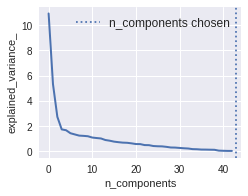

In [459]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model, decomposition, datasets
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

logistic = linear_model.LogisticRegression()

pca = decomposition.PCA()
pipe = Pipeline(steps=[('pca', pca), ('logistic', logistic)])

X_digits = ext_data
y_digits = y_extension

# Plot the PCA spectrum
pca.fit(X_digits)

plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')

# Prediction
n_components = [20, 40, 43]
Cs = np.logspace(-4, 4, 3)

# Parameters of pipelines can be set using ‘__’ separated parameter names:
estimator = GridSearchCV(pipe,
                         dict(pca__n_components=n_components,
                              logistic__C=Cs))
estimator.fit(X_digits, y_digits)

plt.axvline(estimator.best_estimator_.named_steps['pca'].n_components,
            linestyle=':', label='n_components chosen')
plt.legend(prop=dict(size=12))
plt.show()